In [1]:
from typing import List, Tuple, Dict, Set, Union, Any, cast, Optional
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import math
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from collections import Counter
import os
import pickle

### Define dimensions and params
* We use a simple character:token mapping
* The embedding dim can be whatever you want, but because we later add the input to the attention output it is handy to keep them the same.

In [2]:
characters = list(' abcdefghijklmnopqrstuvwxyz')
c_to_t = {c: i for i, c in enumerate(characters)}
t_to_c = {i: c for i, c in enumerate(characters)}

text = 'this will get truncatedHello world!'
short_text = 'hello'
vocab_size = len(characters)
seq_len = 6
embedding_size = 4
attend_dim = embedding_size # not stictly speaking required, but makes things easier.
hidden_size = 4 * embedding_size

### Helper functions to prepare input
* Note that the input will always be of a fixed size, it is truncated or padded as required
* Our padding token 0 is equivalent to " " which is convenient.

In [3]:
def tokenize(text: str) -> List[int]:
    text = text.lower()
    text = ''.join([c for c in text if c in characters])
    tokens = [c_to_t[c] for c in text]
    padding = [0] * (seq_len - len(tokens))
    tokens = padding + tokens
    return tokens[-seq_len:]

def decode(tokens: List[int]) -> str:
    text = ''.join([t_to_c[t] for t in tokens])
    text = text.strip(' ')
    return text

Examples
* Note how the long text has been truncated. The short, padded.

In [4]:
x = tokenize(text)
decoded = decode(x)

x2 = tokenize(short_text)
decoded2 = decode(x2)

print(x)
print(decoded)
print(x2)
print(decoded2)

[0, 23, 15, 18, 12, 4]
world
[0, 8, 5, 12, 12, 15]
hello


### Embedding
* Each input token is projected to embedding dim
* We add a simple positional matrix to give the model information about the seq order

In [5]:
embedding = nn.Embedding(vocab_size, embedding_size)
position_embedding_table = nn.Embedding(seq_len, embedding_size)
pos_emb = position_embedding_table(torch.arange(seq_len))

embedded = embedding(torch.tensor(x))
x = embedded + pos_emb

print((x.shape[0], x.shape[1]) == (seq_len, embedding_size))
x

True


tensor([[-1.7979,  1.8933,  1.1957,  0.4932],
        [-0.4770,  1.9857, -0.5362,  0.0761],
        [-1.6390,  0.5282,  2.4518, -1.1400],
        [ 0.3504, -1.1062, -1.3629,  1.7884],
        [-0.2380, -1.9347,  4.6829,  1.2687],
        [-1.6528,  1.0819, -1.9248, -0.0388]], grad_fn=<AddBackward0>)

### The Q K V matrices
* Each of the 3 matrices is created using their respective weight matrices, which are learned params

In [6]:
qw = nn.Parameter(torch.randn(embedding_size, attend_dim)*0.1)
kw = nn.Parameter(torch.randn(embedding_size, attend_dim)*0.1)
vw = nn.Parameter(torch.randn(embedding_size, attend_dim)*0.1)

q = x @ qw
k = x @ kw
v = x @ vw

(q.shape[0], q.shape[1]) == (seq_len, attend_dim)

True

### The attention score
* dot product of each row of q and k
* Add an attention mask to stop tokens from looking ahead


In [7]:
attention_scores = q @ k.T # shape: seq_len, seq_len 
attention_scores = attention_scores / math.sqrt(attend_dim)
tril = torch.tril(torch.ones(seq_len, seq_len))
attention_scores = attention_scores.masked_fill(tril == 0, float('-inf'))
attention_scores

tensor([[-0.1436,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0120,  0.0390,    -inf,    -inf,    -inf,    -inf],
        [-0.2057, -0.1787, -0.1311,    -inf,    -inf,    -inf],
        [ 0.1084,  0.0694,  0.0896, -0.0651,    -inf,    -inf],
        [-0.1738, -0.2328, -0.0738,  0.1702,  0.4470,    -inf],
        [-0.0122,  0.0260, -0.0134, -0.0312, -0.0841,  0.0066]],
       grad_fn=<MaskedFillBackward0>)

### Softmax each row
* each row represents the attention score of that position in the sequence
* we softmax rows so that they sum to 1

In [8]:
scaled_scores = attention_scores.softmax(dim=1)
scaled_scores

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4873, 0.5127, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3221, 0.3309, 0.3470, 0.0000, 0.0000, 0.0000],
        [0.2643, 0.2542, 0.2594, 0.2222, 0.0000, 0.0000],
        [0.1583, 0.1492, 0.1749, 0.2232, 0.2944, 0.0000],
        [0.1675, 0.1741, 0.1673, 0.1644, 0.1559, 0.1707]],
       grad_fn=<SoftmaxBackward0>)

### Finally we use the attention scores


In [9]:
final = scaled_scores @ v # shape: seq_len, attend_dim @ seq_len, attend_dim -> seq_len, attend_dim
final

tensor([[-0.2847,  0.2462,  0.0232,  0.5764],
        [-0.2495,  0.1855,  0.1669,  0.3882],
        [-0.2152,  0.1882,  0.1061,  0.4189],
        [-0.1320,  0.1102,  0.0016,  0.2920],
        [-0.0676,  0.1275, -0.2507,  0.2108],
        [-0.0887,  0.0887, -0.1002,  0.2695]], grad_fn=<MmBackward0>)

### Now the residual connection is added
* If we had a different attention dim and embedding dim this would not be possible

In [10]:
x = x + final
x

tensor([[-2.0826,  2.1394,  1.2188,  1.0696],
        [-0.7265,  2.1711, -0.3693,  0.4643],
        [-1.8541,  0.7164,  2.5579, -0.7210],
        [ 0.2184, -0.9961, -1.3614,  2.0804],
        [-0.3057, -1.8072,  4.4321,  1.4795],
        [-1.7416,  1.1706, -2.0249,  0.2306]], grad_fn=<AddBackward0>)

### Lets keep our values inside a reasonable range

In [11]:
ln = nn.LayerNorm(embedding_size)
x = ln(x)
x

tensor([[-1.6739,  0.9741,  0.3967,  0.3031],
        [-0.9940,  1.5975, -0.6745,  0.0710],
        [-1.2296,  0.3282,  1.4442, -0.5429],
        [ 0.1735, -0.7305, -1.0024,  1.5593],
        [-0.5404, -1.1868,  1.4991,  0.2281],
        [-0.8598,  1.3171, -1.0717,  0.6144]],
       grad_fn=<NativeLayerNormBackward0>)

### Now pass through a ff network

In [12]:
ff = nn.Sequential(
    nn.Linear(embedding_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, embedding_size),
    nn.Dropout()
)

x = x + ff(x)
x

tensor([[-1.6739,  0.9741,  0.3967,  0.3031],
        [-0.9940,  1.8321, -0.9439, -0.1134],
        [-1.9333,  0.3282,  1.0219, -0.2790],
        [ 0.1735, -0.7305, -1.0024,  1.5593],
        [-0.4419, -1.1868,  1.1029,  0.2281],
        [-1.0300,  1.5588, -1.2678,  0.6144]], grad_fn=<AddBackward0>)

### Once again normalize

In [13]:
ln2 = nn.LayerNorm(embedding_size)
x = ln2(x)
x

tensor([[-1.6739,  0.9741,  0.3967,  0.3031],
        [-0.8208,  1.6492, -0.7771, -0.0513],
        [-1.5711,  0.4974,  1.1318, -0.0581],
        [ 0.1735, -0.7305, -1.0024,  1.5593],
        [-0.4353, -1.3178,  1.3948,  0.3584],
        [-0.8540,  1.3594, -1.0574,  0.5520]],
       grad_fn=<NativeLayerNormBackward0>)

## Multiheaded attention
* Lets start by creating a head

In [14]:
characters = list(' abcdefghijklmnopqrstuvwxyz')
c_to_t = {c: i for i, c in enumerate(characters)}
t_to_c = {i: c for i, c in enumerate(characters)}

def tokenize(text: str) -> List[int]:
    text = text.lower()
    text = ''.join([c for c in text if c in characters])
    tokens = [c_to_t[c] for c in text]
    padding = [0] * (seq_len - len(tokens))
    tokens = padding + tokens
    return tokens[-seq_len:]

def decode(tokens: List[int]) -> str:
    text = ''.join([t_to_c[t] for t in tokens])
    text = text.strip(' ')
    return text

In [15]:
class Head(nn.Module):
    def __init__(self,seq_len, embedding_size, head_size) -> None:
        super().__init__()
        self.seq_len = seq_len
        self.embedding_size = embedding_size
        self.head_size = head_size
        self.k  = nn.Linear(embedding_size, head_size, bias=False)
        self.q  = nn.Linear(embedding_size, head_size, bias=False)
        self.v  = nn.Linear(embedding_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.dropout = nn.Dropout()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        k = self.k(x)
        q = self.q(x)
        v = self.v(x)
        scores = q @ k.T
        scores = scores / math.sqrt(self.head_size)
        scores = scores.masked_fill(self.tril == 0, float('-inf'))
        scores = F.softmax(scores, dim=1)
        scores = self.dropout(scores)
        out = scores @ v
        assert out.shape == (self.seq_len, self.head_size)
        return out

class FeedFoward(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_size, 4 * embedding_size),
            nn.ReLU(),
            nn.Linear(4 * embedding_size, embedding_size),
            nn.Dropout(),
        )

    def forward(self, x):
        out = self.net(x)
        return out

class MultiHead(nn.Module):
    def __init__(self, embedding_size, n_heads, head_size, seq_len):
        super().__init__()

        self.heads = nn.ModuleList([Head(seq_len, embedding_size, head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_heads * head_size, embedding_size,bias=False)
        self.ln1 = nn.LayerNorm(embedding_size)
        self.ff = FeedFoward(embedding_size)
        self.ln2 = nn.LayerNorm(embedding_size)
    
    def forward(self, x):
        heads = [head(x) for head in self.heads]
        out = torch.cat(heads, dim=1)
        out = self.proj(out)
        out = x + out
        out = self.ln1(out)
        out = self.ff(out)
        out = out + x
        out = self.ln2(out)
        return out

class Transformer(nn.Module):
    def __init__(self,params):
        super().__init__()
        vocab_size = params['vocab_size']
        embedding_size = params['embedding_size']
        n_heads = params['n_heads']
        head_size = params['head_size']
        n_layers = params['n_layers']
        seq_len = params['seq_len']
        self.seq_len = params['seq_len']

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding_table = nn.Embedding(seq_len, embedding_size)
        self.attn_blocks = [MultiHead(embedding_size, n_heads, head_size,seq_len) for _ in range(n_layers)]
        self.vocab_proj = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        pos_emb = self.position_embedding_table(torch.arange(self.seq_len))
        x = embedded + pos_emb
        for block in self.attn_blocks:
            x = block(x)
        x = self.vocab_proj(x)
        return x

    def generate(self):
        x = torch.zeros(self.seq_len, dtype=torch.long)
        text = ''
        for i in range(50):
            out = self.forward(x)
            out = out[-1]
            out = out.softmax(dim=0)
            #multinomial sampling
            idx = torch.multinomial(out, num_samples=1)
            x = torch.cat([x[1:], idx])
            c = t_to_c[idx.item()]
            text += c
        return text

    
    def train_model(
        self,
        p: Dict[str, Any]
    ):
        # train_loader = DataLoader(p['train_dataset'], batch_size=p['batch_size'], shuffle=True)
        optimizer = p['optimizer'](self.parameters(), lr=p['lr'])
        scheduler = p['scheduler'](optimizer,patience=p['patience'])
        loss_fn = p['loss_fn']

        accumulated_loss = 0.0
        losses = []

        # Warmup Phase
        if p['warmup_steps'] is not None:
            print("Starting warmup")
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01 * p['lr']
            for i, (x, y) in enumerate(p['train_dataset']):
                if i >= p['warmup_steps']:
                    break
                out = self(x)
                loss = loss_fn(out, y)
                loss.backward()
                accumulated_loss += loss.item()
                if (i + 1) % p['gradient_accumulation_steps'] == 0:
                    optimizer.step()
                    accumulated_loss = 0.0
                    optimizer.zero_grad()
            print("Finished warmup")
            for param_group in optimizer.param_groups:
                param_group['lr'] = p['lr']
            
        accumulated_loss = 0.0
        for epoch in range(p['epochs']):
            for i, (x, y) in enumerate(p['train_dataset']):

                out = self(x)
                loss = loss_fn(out, y)
                loss.backward()
                accumulated_loss += loss.item()

                # Ensuring that batch_size and gradient_accumulation_steps line up
                if (i + 1) % p['gradient_accumulation_steps'] == 0:
                    optimizer.step()
                    avg_loss = accumulated_loss / p['gradient_accumulation_steps']
                    losses.append(avg_loss)
                    accumulated_loss = 0.0
                    optimizer.zero_grad()
                    scheduler.step(avg_loss)

                if (i + 1) % 1000 == 0:
                    print("Average loss:", avg_loss)
                    print(f"percent complete: {(i+1)/len(p['train_dataset']) * 100:.2f}%")
                    print(self.generate())
                if i > 2000:
                    break
            print(f"Epoch {epoch} complete")
        return losses
    
    def train_model_profile(self, p: Dict[str, Any]):
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
            with record_function("model_training"):
                losses = self.train_model(p)
        return losses, prof

In [16]:
tinystories_dataset = load_dataset("roneneldan/TinyStories")
tinystories_dataset = tinystories_dataset['train']['text']
    
class SlidingWindowDataset(Dataset):
    def __init__(self, stories: list, seq_len: int):
        super(SlidingWindowDataset, self).__init__()
        self.seq_len = seq_len
        self.stories = ' '.join([s for s in stories[:10000]])
        self.tokenized_data = [c_to_t[c.lower()] for c in self.stories if c.lower() in characters]

    def __len__(self) -> int:
        # Adjust the length so that the last data point has at least seq_len elements remaining
        return len(self.tokenized_data) - 2 * self.seq_len + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Calculate the ending index for x and y
        end_idx_x = idx + self.seq_len
        end_idx_y = idx + 1 + self.seq_len

        # Get the actual data
        x_data = self.tokenized_data[idx: end_idx_x]
        y_data = self.tokenized_data[idx + 1: end_idx_y]
        
        # Pad if necessary
        x_data += [0] * (self.seq_len - len(x_data))
        y_data += [0] * (self.seq_len - len(y_data))
        
        # Convert to tensors
        x = torch.tensor(x_data, dtype=torch.long)
        y = torch.tensor(y_data, dtype=torch.long)
        
        assert len(x) == len(y) == self.seq_len
        return x, y

Repo card metadata block was not found. Setting CardData to empty.


In [17]:
model_params = {
    'vocab_size': len(characters),
    'seq_len': 50,
    'embedding_size': 256,
    'n_heads': 8,
    'head_size': 32,
    'n_layers': 4, # transformer blocks
}
assert model_params['embedding_size'] / model_params['n_heads'] == model_params['head_size']

model = Transformer(model_params)

train_params = {
    'epochs': 6,
    'gradient_accumulation_steps': 1,
    'warmup_steps': 1000,
    'lr': 0.001,
    'lr_scheduler': None,
    'batch_size': 32,
    'train_dataset': SlidingWindowDataset(tinystories_dataset, model_params['seq_len']),
    'optimizer': torch.optim.Adam,
    'loss_fn': nn.CrossEntropyLoss(),
    'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'patience': 5,
}



In [18]:
model.generate()

'ewdfyf jrpjrtprcukbpjnhkfvqjnwcfrkfrthujrvxstecjhw'

In [19]:
losses = model.train_model(train_params)

Starting warmup
Finished warmup
Average loss: 2.4978575706481934
percent complete: 0.01%
amroumjjqrndrrm a wsy acomhw z kn qjfx rlezomggled
Average loss: 2.785243034362793
percent complete: 0.02%
ze d h dtxfdte wyoufpjtv anwf swa sjplmpxwr kshed 
Epoch 0 complete
Average loss: 2.404512643814087
percent complete: 0.01%
vln wrl ir  r ed uwyzeasd lmed tper s iyhhcts sh a
Average loss: 2.7579262256622314
percent complete: 0.02%
krrro knedrnkgkaftnkzqqxwci it nt nacn nun ordjymg
Epoch 1 complete
Average loss: 2.551711320877075
percent complete: 0.01%
alephedanir ikuo r noedgcylpqhikhed s r iwhtkohedm
Average loss: 2.793362617492676
percent complete: 0.02%
he wreoudxly phezd ned tny ns nyglerofqiliz d ko t
Epoch 2 complete
Average loss: 2.496868848800659
percent complete: 0.01%
l vvhknfywl hgply na n rcfn iyiqkhmiy namlyftlybre
Average loss: 2.7518415451049805
percent complete: 0.02%
ayzaun fungedoommed g nly iyo r ndnmbcplen sw nybh
Epoch 3 complete
Average loss: 2.445382833480835
percent c

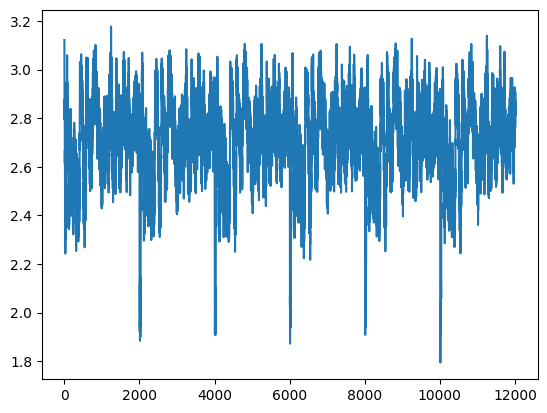

In [20]:
plt.plot(losses)
plt.show()